In [1]:
# === Imports ===
import gc
import sys
import os 
import warnings
import time
import numpy as np
import pandas as pd
from keras.callbacks import EarlyStopping
from tensorflow.python.framework.random_seed import set_random_seed
from deep_models import CNN
from metrics import measure_performance
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
# function to sample N synthetic values and augment training data
def augment_synth_data(run_file_num, synth_amount):

    synth_data = pd.read_csv("../data/chlorinated/" + file_name + "/" + file_name + "_run_" + str(run_file_num) + "_train.csv")

    if synth_amount == "all":
        return synth_data 
    
    elif synth_amount > 0:
        pos_sample_percentage = round(synth_amount * 0.6677740863787376)  # positive label percentage
        neg_sample_percentage = synth_amount - pos_sample_percentage  # sample 33% negative samples
        
        # sample for augmentation
        positive_samples = synth_data.loc[synth_data["classLabel"] == 1] \
            .sample(n=pos_sample_percentage, replace=False)
        
        negative_samples = synth_data.loc[synth_data["classLabel"] == 0] \
            .sample(n=neg_sample_percentage, replace=False)
                
        # vertical concat -> row-wise
        return pd.concat([positive_samples, negative_samples], axis=0)

In [3]:
# === HYPERPARAMTERS ===
_BATCH = 1
_EPOCHS = 100
_VERBOSITY = 0
criterion = EarlyStopping(monitor="loss", patience=5)
NUM_SEED = 5
NUM_RUN = 3
input_dim = 2473

run_list = []
seed_list = []

# === Train Results Lists ===
train_acc_list = []
train_epochs_acc_list = []
train_bal_acc_list = []
train_loss_curves = []
train_tp_list = []
train_tn_list = []
train_fp_list = []
train_fn_list = []
train_f1_list = []
train_recall_list = []
train_precision_list = []

# === Test Results Lists ===
test_acc_list = []
test_bal_acc_list = []
test_tp_list = []
test_tn_list = []
test_fp_list = []
test_fn_list = []
test_f1_list = []
test_recall_list = []
test_precision_list = []

# synth data controllers, only 1 should be True at any time
is_blended = False
is_vae = True

# synths file names
if is_blended:
    file_name = "blended"
elif is_vae:
    file_name = "vae"
else:
    file_name = "orig"
    
# 0, amount wanted or "all"
synth_amount = 1200

In [4]:
# track training time
start_time = time.time()

for run in range(1, NUM_RUN + 1):
    print("######################### RUN %d #########################" % run)
    
    ################
    # DATA #
    ################
    
    # === DATA SOURCES ===
    run_training_file = "../data/chlorinated/orig/orig_run_" + str(run) + "_train.csv"
    run_holdout_file = "../data/chlorinated/orig/orig_run_" + str(run) + "_holdout.csv"
    
    training_data = pd.read_csv(run_training_file, header=0)
    
    # concat training data with current augmentation
    if is_blended or is_vae:
        synth_data = augment_synth_data(run, synth_amount)
        training_data = pd.concat([training_data, synth_data])
        
        print(f'Synth samples added: {synth_data.shape[0]}')
        del synth_data
    
    # split features and labels
    X_train = training_data.iloc[:, :-1].to_numpy()
    X_train = X_train.reshape(-1, 1, input_dim, 1)
    
    y_train = training_data.iloc[:, -1].to_numpy()
    
    # holdout file
    test_data = pd.read_csv(run_holdout_file, header=0)
    X_test = test_data.iloc[:, :-1].to_numpy()
    X_test = X_test.reshape(-1, 1, input_dim, 1)
    
    y_test = test_data.iloc[:, -1].to_numpy()
    
    print("Total training samples = %d" % X_train.shape[0])
    print("Total holdout samples = %d" % y_test.shape[0])

    # clean memory
    del training_data
    del test_data
    del run_training_file
    del run_holdout_file
    gc.collect()
    
    ################
    # TRAINING # 
    ################
    
    print('Run', '\t', 'Seed', '\t', 'Test Accuracy', '\t', "Balanced Test Accuracy")

    for seed in range(0, NUM_SEED):
        # reproducibility
        set_random_seed(seed)
        np.random.seed(seed)
        
        run_list.append(run)
        seed_list.append(seed)

        # import & create new model
        model = CNN(input_dim)

        # train model
        fit = model.fit(X_train, y_train, epochs=_EPOCHS, batch_size=_BATCH,
                        shuffle=True, verbose=_VERBOSITY)
        
        train_loss_curves.append(fit.history['loss'])
        train_epochs_acc_list.append(fit.history['acc'])

        # get training metrics
        train_accuracy, train_bal_accuracy, train_precision, train_recall, \
        train_f1, train_tn, train_fp, train_fn, train_tp = measure_performance(model, X_train, y_train)
        
        # get test metrics
        test_accuracy, test_bal_accuracy, test_precision, test_recall, \
        test_f1, test_tn, test_fp, test_fn, test_tp = measure_performance(model, X_test, y_test)
        
        # update train metric lists
        train_acc_list.append(train_accuracy)
        train_bal_acc_list.append(train_bal_accuracy)
        train_precision_list.append(train_precision)
        train_recall_list.append(train_recall)
        train_f1_list.append(train_f1)
        train_tn_list.append(train_tn)
        train_fp_list.append(train_fp)
        train_fn_list.append(train_fn)
        train_tp_list.append(train_tp)
        
        # update train metric lists
        test_acc_list.append(test_accuracy)
        test_bal_acc_list.append(test_bal_accuracy)
        test_precision_list.append(test_precision)
        test_recall_list.append(test_recall)
        test_f1_list.append(test_f1)
        test_tn_list.append(test_tn)
        test_fp_list.append(test_fp)
        test_fn_list.append(test_fn)
        test_tp_list.append(test_tp)
        
        print(run, '\t', seed, '\t', test_accuracy, '\t', test_bal_accuracy)
    
    # clear data to load fresh (cache issue in notebook)
    del X_train 
    del y_train
    del X_test
    del y_test
    del model
    del fit
    gc.collect()
        
    print()
    
print("CNN took approx: %s minutes" % round((time.time() - start_time) / 60, 4))

######################### RUN 1 #########################
Synth samples added: 1200
Total training samples = 1276
Total holdout samples = 154
Run 	 Seed 	 Test Accuracy 	 Balanced Test Accuracy
1 	 0 	 0.8896103896103896 	 0.863030649152865
1 	 1 	 0.7987012987012987 	 0.824766799923853
1 	 2 	 0.8506493506493507 	 0.833904435560632
1 	 3 	 0.8051948051948052 	 0.8197220635827147
1 	 4 	 0.9090909090909091 	 0.8874928612221588

######################### RUN 2 #########################
Synth samples added: 1200
Total training samples = 1276
Total holdout samples = 154
Run 	 Seed 	 Test Accuracy 	 Balanced Test Accuracy
2 	 0 	 0.7532467532467533 	 0.7066438225775746
2 	 1 	 0.7597402597402597 	 0.7164477441462022
2 	 2 	 0.7662337662337663 	 0.7262516657148296
2 	 3 	 0.7662337662337663 	 0.7262516657148296
2 	 4 	 0.7532467532467533 	 0.7066438225775746

######################### RUN 3 #########################
Synth samples added: 1200
Total training samples = 1276
Total holdout sampl

In [5]:
# === SAVE RESULTS ===
# converts results lists to dataframe
results_folder = "../results/chlorinated/" + file_name
    
test_results = pd.DataFrame({'run': run_list, 'seed': seed_list, 'accuracy': test_acc_list, "bal_accuracy": test_bal_acc_list,
                             "precision": test_precision_list, "recall": test_recall_list, 
                             "f1": test_f1_list, "tp": test_tp_list, "fp": test_fp_list, 
                             "tn": test_tn_list, "fn": test_fn_list})

# calculates the mean accuracies and the associated standard deviation
test_means = test_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].mean()
test_standard_deviations = test_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].std()

test_means = test_means.add_prefix("mean_")
test_standard_deviations = test_standard_deviations.add_prefix("std_")

# # creates dataframe of mean and standard deviation aggregate values
test_results_summary = pd.concat([test_means.round(3), test_standard_deviations.round(3)], axis=1)

# # get mean of all 3 runs
test_results_summary.loc["run_mean"] = test_results_summary.mean().round(3)

# # Save results to File
test_results.to_csv(results_folder + "/test_cnn_results_" + str(synth_amount) + ".csv", index=False)
test_results_summary.to_csv(results_folder + "/test_cnn_results_summary_" + str(synth_amount) + ".csv")

test_results_summary

,mean_accuracy,mean_bal_accuracy,mean_precision,mean_recall,mean_f1,std_accuracy,std_bal_accuracy,std_precision,std_recall,std_f1
run,,,,,,,,,,
1,0.851,0.846,0.913,0.860,0.883,0.049,0.029,0.019,0.094,0.045
2,0.760,0.716,0.806,0.845,0.825,0.006,0.010,0.007,0.000,0.004
3,0.879,0.837,0.877,0.959,0.915,0.052,0.078,0.057,0.035,0.034
run_mean,0.830,0.800,0.865,0.888,0.874,0.036,0.039,0.028,0.043,0.028


In [6]:
# === SAVE RESULTS ===
# converts results lists to dataframe
results_folder = "../results/chlorinated/" + file_name

# results from training set evaluation (not epochs)
train_results = pd.DataFrame({'run': run_list, 'seed': seed_list, 'accuracy': train_acc_list, "bal_accuracy": train_bal_acc_list,
                             "precision": train_precision_list, "recall": train_recall_list, 
                             "f1": train_f1_list, "tp": train_tp_list, "fp": train_fp_list, 
                             "tn": train_tn_list, "fn": train_fn_list})

train_results

# calculates the mean accuracies and the associated standard deviation
train_means = train_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].mean()
train_standard_deviations = train_results.groupby(['run'])["accuracy", "bal_accuracy", "precision", "recall", "f1"].std()

train_means = train_means.add_prefix("mean_")
train_standard_deviations = train_standard_deviations.add_prefix("std_")

# creates dataframe of mean and standard deviation aggregate values
train_results_summary = pd.concat([train_means.round(3), train_standard_deviations.round(3)], axis=1)
train_results_summary

# get mean of all 3 runs
train_results_summary.loc["run_mean"] = train_results_summary.mean().round(3)

# Save results to File
train_results.to_csv(results_folder + "/train_cnn_results_" + str(synth_amount) + ".csv", index=False)
train_results_summary.to_csv(results_folder + "/train_cnn_results_summary_" + str(synth_amount) + ".csv")

train_results_summary

,mean_accuracy,mean_bal_accuracy,mean_precision,mean_recall,mean_f1,std_accuracy,std_bal_accuracy,std_precision,std_recall,std_f1
run,,,,,,,,,,
1,0.999,0.999,0.999,1.0,0.999,0.001,0.002,0.002,0.000,0.001
2,1.000,1.000,1.000,1.0,1.000,0.000,0.000,0.000,0.000,0.000
3,1.000,1.000,1.000,1.0,1.000,0.000,0.000,0.000,0.001,0.000
run_mean,1.000,1.000,1.000,1.0,1.000,0.000,0.001,0.001,0.000,0.000


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,7.029180,2.181015,1.044237,0.782501,0.641740,0.598798,0.558963,0.533360,0.516058,0.496055,...,0.010992,0.008479,0.025163,0.019955,0.019233,0.026404,0.015212,0.025204,0.015686,0.015241
1,7.011710,2.070468,1.051573,0.752036,0.648395,0.599897,0.570458,0.519146,0.491304,0.462931,...,0.030374,0.028122,0.021079,0.025180,0.034209,0.027111,0.024981,0.020782,0.027081,0.027973
2,7.195464,2.069642,1.064398,0.732278,0.595210,0.524734,0.439576,0.387458,0.344702,0.302075,...,0.016084,0.014558,0.013719,0.007497,0.005033,0.008768,0.006311,0.017505,0.012125,0.010492


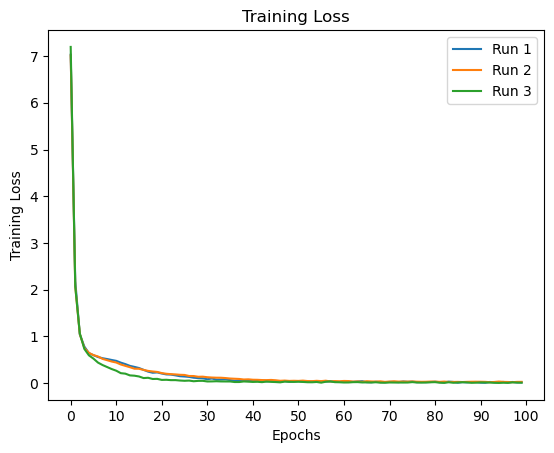

In [7]:
df_train_loss = pd.DataFrame(train_loss_curves)
df_train_loss.to_csv(results_folder + "/cnn_train_loss_" + str(synth_amount) + ".csv", index=False)

train_loss_means = df_train_loss.groupby(np.arange(len(df_train_loss))//5).mean()

# plot training loss curves
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.xticks(range(0, _EPOCHS+1, 10))

plt.plot(train_loss_means.iloc[0, :],  label="Run 1")
plt.plot(train_loss_means.iloc[1, :], label="Run 2")
plt.plot(train_loss_means.iloc[2, :], label="Run 3")

plt.legend()
#plt.savefig(results_folder + "/cnn_chlo_" + str(synth_amount) + "_training_loss.png")

train_loss_means

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.589342,0.629937,0.658777,0.659718,0.687461,0.706270,0.714577,0.734953,0.747022,0.761285,...,0.996865,0.998119,0.995455,0.995298,0.994984,0.994201,0.995925,0.994828,0.996395,0.995925
1,0.587931,0.620846,0.648903,0.667241,0.692320,0.711912,0.722571,0.749843,0.761442,0.776176,...,0.990752,0.991536,0.992476,0.990282,0.991223,0.992633,0.992476,0.992320,0.990439,0.990596
2,0.589342,0.640439,0.671003,0.713480,0.740282,0.767085,0.807210,0.830408,0.850313,0.876803,...,0.997492,0.997022,0.997492,0.998276,0.998903,0.998276,0.998746,0.997492,0.997962,0.999060


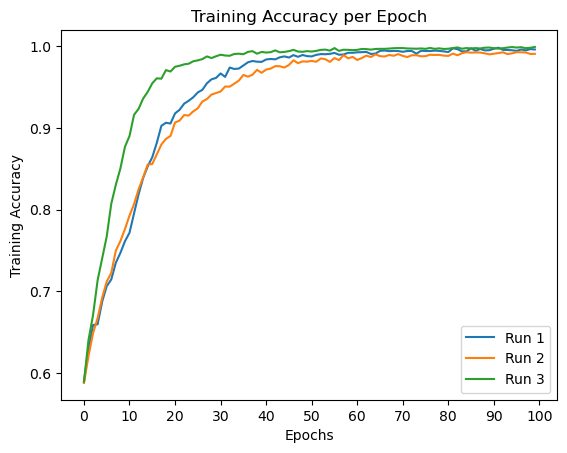

In [8]:
df_train_epoch_acc = pd.DataFrame(train_epochs_acc_list)
df_train_epoch_acc.to_csv(results_folder + "/cnn_epoch_train_loss_" + str(synth_amount) + ".csv", index=False)

train_acc_means = df_train_epoch_acc.groupby(np.arange(len(df_train_epoch_acc))//5).mean()

# plot training acc
plt.title("Training Accuracy per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy")
plt.xticks(range(0, _EPOCHS+1, 10))

plt.plot(train_acc_means.iloc[0, :], label="Run 1")
plt.plot(train_acc_means.iloc[1, :], label="Run 2")
plt.plot(train_acc_means.iloc[2, :], label="Run 3")

plt.legend()
#plt.savefig(results_folder + "/cnn_chlo_" + str(synth_amount) + "_training_acc.png")

train_acc_means

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.88961,0.798701,0.850649,0.805195,0.909091,0.753247,0.75974,0.766234,0.766234,0.753247,0.855263,0.914474,0.888158,0.802632,0.934211


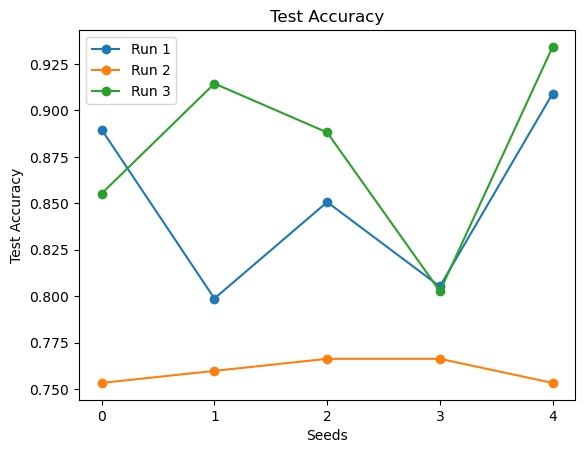

In [9]:
# plot acc curves
plt.title("Test Accuracy")
plt.xlabel("Seeds")
plt.ylabel("Test Accuracy")
plt.xticks(range(0, NUM_SEED))

plt.plot(test_acc_list[0:5], "o-", label="Run 1")
plt.plot(test_acc_list[5:10], "o-", label="Run 2")
plt.plot(test_acc_list[10:15], "o-", label="Run 3")

plt.legend()
#plt.savefig(results_folder + "/cnn_chlo_" + str(synth_amount) + "_test_acc.png")

pd.DataFrame(test_acc_list).T